## Phần 1: Mô tả bài toán

### 1.1. Phát biểu bài toán

**Nhiệm vụ**: Phân loại hình ảnh trên tập dữ liệu CIFAR-10.
Quy trình bao gồm hai bước chính:
1.  **Trích xuất đặc trưng (Feature Extraction)**: Sử dụng mô hình **Convolutional Autoencoder** để học biểu diễn nén (latent representation) của hình ảnh. Autoencoder sẽ học cách mã hóa ảnh đầu vào thành một vector đặc trưng chiều thấp và tái tạo lại ảnh gốc từ vector đó.
2.  **Phân loại (Classification)**: Sử dụng bộ phân loại **Support Vector Machine (SVM)** để phân lớp hình ảnh dựa trên các vector đặc trưng thu được từ Autoencoder.

### 1.2. Tổng quan về bộ dữ liệu CIFAR-10

- **Kích thước**: 60.000 hình ảnh màu (RGB).
- **Độ phân giải**: 32x32 pixels.
- **Số lớp (Classes)**: 10 lớp (Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, Truck).
- **Phân chia dữ liệu**:
    - Tập huấn luyện (Training set): 50.000 ảnh.
    - Tập kiểm tra (Test set): 10.000 ảnh.
- **Tiền xử lý (Preprocessing)**:
    - Chuẩn hóa giá trị pixel từ [0, 255] về khoảng [0, 1].
    - Dữ liệu được đọc từ các file binary (`data_batch_*.bin`).

100%|██████████| 170M/170M [00:38<00:00, 4.47MB/s] 


Sample from CIFAR-10:


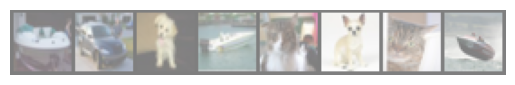

Labels ship  car   dog   ship  cat   dog   cat   ship 


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

try:
    transform = transforms.Compose([transforms.ToTensor()])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    dataiter = iter(torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True))
    images, labels = next(dataiter)

    print('Sample from CIFAR-10:')
    imshow(torchvision.utils.make_grid(images))
    print('Labels', ' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))
except Exception as e:
    print(f"Can not load data: {e}")

### 1.3. Kiến trúc Autoencoder

Mô hình mạng nơ-ron được thiết kế như sau:

#### **Encoder (Mã hóa)**
Mục tiêu: Giảm chiều dữ liệu và trích xuất đặc trưng.
1.  **Input**: 3 x 32 x 32
2.  **Conv1**: 3 $\to$ 256 kênh, Kernel 3x3, Padding 1. $\to$ Output: 256 x 32 x 32.
    - Activation: ReLU.
    - MaxPool: 2x2. $\to$ Output: 256 x 16 x 16.
3.  **Conv2**: 256 $\to$ 128 kênh, Kernel 3x3, Padding 1. $\to$ Output: 128 x 16 x 16.
    - Activation: ReLU.
    - MaxPool: 2x2. $\to$ Output: 128 x 8 x 8.
4.  **Latent Representation (Bottleneck)**: 128 x 8 x 8 (8192 chiều).

#### **Decoder (Giải mã)**
Mục tiêu: Tái tạo lại hình ảnh gốc từ đặc trưng.
5.  **Conv3**: 128 $\to$ 128 kênh, Kernel 3x3, Padding 1. $\to$ Output: 128 x 8 x 8.
    - Activation: ReLU.
    - Upsample: 2x. $\to$ Output: 128 x 16 x 16.
6.  **Conv4**: 128 $\to$ 256 kênh, Kernel 3x3, Padding 1. $\to$ Output: 256 x 16 x 16.
    - Activation: ReLU.
    - Upsample: 2x. $\to$ Output: 256 x 32 x 32.
7.  **Conv5**: 256 $\to$ 3 kênh, Kernel 3x3, Padding 1. $\to$ Output: 3 x 32 x 32.
    - (Không dùng hàm kích hoạt cuối cùng để output giá trị thực pixel).

### 1.4. Mục tiêu dự án

1.  **Hiệu năng**: Đạt được tốc độ huấn luyện nhanh hơn đáng kể trên GPU so với phiên bản CPU (mục tiêu speedup > 10x).
2.  **Độ chính xác**: Mô hình Autoencoder có khả năng tái tạo ảnh tốt (Loss thấp) và đặc trưng trích xuất đủ tốt để SVM phân loại với độ chính xác chấp nhận được.
3.  **Kỹ thuật**: Nắm vững các kỹ thuật tối ưu hóa CUDA như Shared Memory Tiling, Stream processing, và tối ưu hóa bộ nhớ (Memory coalescing).

## Phần 2: Các giai đoạn hiện thực

### Giai đoạn 2.1: Hiện thực CPU Baseline

**Mục tiêu**:
Hiện thực phiên bản Autoencoder hoàn chỉnh chạy trên CPU bằng ngôn ngữ C++. Phiên bản này đóng vai trò là chuẩn (baseline) để kiểm tra tính đúng đắn (correctness) của các phiên bản GPU sau này và để so sánh hiệu năng tốc độ.

**Chi tiết hiện thực**:

1.  **Data Pipeline**:
    - Xây dựng lớp `CIFAR10Dataset` trong file `cifar10_loader.h`.
    - Đọc dữ liệu binary từng batch, chuyển đổi byte sang float và chuẩn hóa về [0.0, 1.0].
    - Hỗ trợ shuffle dữ liệu và lấy mini-batch.

2.  **Cài đặt các lớp (Layers)**:
    - `Conv2D`: Thực hiện tích chập với 6 vòng lặp lồng nhau (batch (xử lý ngoài), out_channel, in_channel, height, width, kernel_h, kernel_w).
    - `ReLU`: $f(x) = \max(0, x)$.
    - `MaxPool`: Lấy giá trị lớn nhất trong cửa sổ 2x2.
    - `Upsample`: Nhân đôi kích thước bằng cách lặp lại giá trị pixel (Nearest Neighbor).

3.  **Training Loop**:
    - Forward pass: Tính toán qua từng lớp.
    - Loss calculation: Tính MSE giữa ảnh gốc và ảnh tái tạo.
    - Backward pass: Tính gradient ngược từ loss về các lớp đầu (Backpropagation).
    - Weight update: Cập nhật trọng số theo SGD.

**Key Code Snippets**:

Dưới đây là chữ ký hàm Conv2D và vòng lặp huấn luyện chính trên CPU:

```cpp
// Cài đặt Convolution 2D trên CPU (trích xuất từ src/cpu/autoencoder_cpu.cpp)
Tensor3D AutoencoderCPU::conv2d(
    const Tensor3D& x,
    const std::vector<float>& w,
    const std::vector<float>& b,
    int outC,
    bool use_padding)
{
    // ... setup dimensions ...
    Tensor3D out(outC, H + 2*pad - 2, W + 2*pad - 2);

    for (int oc = 0; oc < outC; oc++) {
        for (int ic = 0; ic < inC; ic++) {
            for (int i = 0; i < out.H; i++) {
                for (int j = 0; j < out.W; j++) {
                    float sum = 0.0f;
                    // Convolution operation
                    for (int ki = 0; ki < k; ki++) {
                        for (int kj = 0; kj < k; kj++) {
                            // ... index calculation and boundary check ...
                            sum += val * weight;
                        }
                    }
                    out.at(oc, i, j) += sum;
                }
            }
        }
        // Add bias
    }
    return out;
}

// Vòng lặp huấn luyện (trích xuất từ src/main.cpp)
// for (int epoch = 0; epoch < epochs; epoch++) {
//     ...
//     for (int start = 0; start < train_dataset.num_images; start += batch_size) {
//         ...
//         for (size_t i = 0; i < batch_images.size(); i++) {
//             Tensor3D input = image_to_tensor3d(batch_images[i]);
//             float loss = autoencoder.train_step(input, learning_rate);
//             batch_loss += loss;
//         }
//         ...
//     }
//     ...
// }
```

In [1]:
!./scripts/build_cpu.sh

Building CPU version...
CPU binary created at: /home/phuc-nguyen22/DOCD/CUDA/Final/build_cpu/autoencoder_cpu


In [2]:
!./build_cpu/autoencoder_cpu ./cifar-10-binary/cifar-10-batches-bin

Hyperparameters:
  Epochs: 5
  Batch size: 32
  Learning rate: 0.001
  Model save path: autoencoder_weights.bin
  Max training images: 1000

Loading CIFAR-10 training data from: ./cifar-10-binary/cifar-10-batches-bin
Loaded 50000 training images
Using 1000 images for training (limited from 50000)
Loaded 10000 test images


=== Training ===
Epoch 1/5 - Shuffling data...
  Processing 32 batches...
  Batch 1/32 ... Loss: 0.248108
  Batch 10/32 ... Loss: 0.0599997
  Batch 20/32 ... Loss: 0.0381286
  Batch 30/32 ... Loss: 0.0325906

Epoch 1/5 - Average Loss: 0.0538583 - Time: 710s
Epoch 2/5 - Shuffling data...
  Processing 32 batches...
  Batch 1/32 ... Loss: 0.0327082
  Batch 10/32 ... Loss: 0.0298208
  Batch 20/32 ... Loss: 0.0269234
  Batch 30/32 ... Loss: 0.0256511

Epoch 2/5 - Average Loss: 0.0284294 - Time: 708s
Epoch 3/5 - Shuffling data...
  Processing 32 batches...
  Batch 1/32 ... Loss: 0.0290784
  Batch 10/32 ... Loss: 0.0268181
  Batch 20/32 ... Loss: 0.024847
  Batch 30/32 ... 

# Kết quả thực nghiệm (CPU)

Dựa trên log huấn luyện 5 epochs với batch size 32, sử dụng 1000 training images:

| Epoch | Average Loss   | Test Loss   | Thời gian (s) | Ghi chú                     |
|-------|----------------|-------------|---------------|-----------------------------|
| 1     | 0.0538583      | -           | 710           | Loss giảm nhanh ban đầu     |
| 2     | 0.0284294      | -           | 708           | Giảm mạnh, hội tụ tốt       |
| 3     | 0.0238843      | -           | 683           | Bắt đầu hội tụ ổn định      |
| 4     | 0.0217132      | -           | 698           | Giảm từ từ                  |
| 5     | 0.019872       | 0.0190731   | 729           | Loss đã ổn định             |

**Average test loss (100 images):** `0.0186718`

**Tổng thời gian huấn luyện:** `3750s` (≈ 62.5 phút)

---

# Nhận xét tổng quan

### 1. Hiệu năng học
- Loss giảm từ **0.053 → 0.019** chỉ trong 5 epochs.
- Training loss và test loss gần nhau → Không overfitting.

### 2. Tốc độ
- Huấn luyện CPU chậm (~12.5 phút/epoch chỉ dùng 1000 ảnh).
- Convolution chiếm phần lớn thời gian.

---

# Key Takeaways

### 1. Convolution rất chậm trên CPU
- Hàm conv2D có **6 vòng lặp lồng nhau**, độ phức tạp rất cao.

### 2. GPU sẽ tăng tốc rất mạnh
- Mỗi pixel và mỗi channel có thể tính độc lập → dễ map sang CUDA thread/block.
- Có thể dùng shared memory + memory coalescing.